# Autoencoders for non-supervised intrusion detection

We train the autoencoders with 'normal' traffic <br>
Then detects abnormal traffic <br>
\
\

In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from tensorflow import keras
from sklearn.preprocessing import normalize
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # to avoid warning messages = 3 

2022-03-04 08:30:36.825585: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-04 08:30:36.825608: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def label_marker(row):
    if isinstance(row['marker'], str) and 'Natural' in row['marker']:
        return 0
    if isinstance(row['marker'], str) and 'Attack' in row['marker']:
        return 1
    return 


In [3]:
path = './data/Zero_Day/'
path_normal = path +'Normal.csv'
path_combine = path +'Combine.csv'

traffic_df = pd.read_csv(path_normal)  
combine_df = pd.read_csv(path_combine)  

combine_df['marker'] = combine_df.apply(label_marker, axis=1)
combine_labels = combine_df['marker'].to_numpy() 
len(combine_labels)

78377

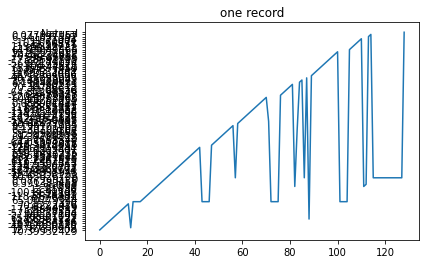

In [4]:
y = traffic_df.iloc[[0]].values.tolist() 
x = list(range(0, len(y[0])))
fig = plt.figure()
plt.plot(x,y[0])
plt.title('one record')
plt.show()

In [5]:
traffic_df.columns

Index(['R1-PA1:VH', 'R1-PM1:V', 'R1-PA2:VH', 'R1-PM2:V', 'R1-PA3:VH',
       'R1-PM3:V', 'R1-PA4:IH', 'R1-PM4:I', 'R1-PA5:IH', 'R1-PM5:I',
       ...
       'control_panel_log4', 'relay1_log', 'relay2_log', 'relay3_log',
       'relay4_log', 'snort_log1', 'snort_log2', 'snort_log3', 'snort_log4',
       'marker'],
      dtype='object', length=129)

In [6]:
# Delete marker column in dataframe as it is not numeric < check with darshana >
traffic_df.drop(['marker'], axis=1, inplace=True)
combine_df.drop(['marker'], axis=1, inplace=True)

In [7]:
# each row of the dataframe is considered a sequence
# we create a numpy array with the sequences
traffic_np = traffic_df.to_numpy()
print('normal shape',traffic_np.shape)
combine_np = combine_df.to_numpy()
print('test shape', combine_np.shape)

normal shape (22714, 128)
test shape (78377, 128)


In [18]:
# This is how it looks
traffic_np
print(traffic_np.shape)

(22714, 128)


In [9]:
# manage NaNs & inf
print('normal traffic NaNs', np.count_nonzero(np.isnan(traffic_np)))
print('normal traffic inf', np.count_nonzero(np.isinf(traffic_np)))
print('combine traffic NaNs', np.count_nonzero(np.isnan(combine_np)))
print('combine traffic inf', np.count_nonzero(np.isinf(combine_np)))
traffic_np = np.nan_to_num(traffic_np, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
combine_np = np.nan_to_num(combine_np, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
# not so sure that inf is correctly set to 0

normal traffic NaNs 0
normal traffic inf 3753
combine traffic NaNs 0
combine traffic inf 10906


In [10]:
# normalize the data on each column
# Normalize and save the mean and std we get,
# for normalizing test data.

traffic_np_norm = normalize(traffic_np, axis=0, norm='max')
combine_np_norm = normalize(combine_np, axis=0, norm='max')

In [11]:
x_train = traffic_np_norm[...,np.newaxis]
x_combine = combine_np_norm[...,np.newaxis]
print("Normal Traffic Training input shape: ", x_train.shape)
print("Combine Traffic Test input shape: ", x_combine.shape)

Normal Traffic Training input shape:  (22714, 128, 1)
Combine Traffic Test input shape:  (78377, 128, 1)


In [148]:
def build_model():
    input_a = layers.Input(shape=(x_train.shape[1], x_train.shape[2]))
    x = layers.Conv1D(filters=256, kernel_size=7, padding="same", strides=2, activation="relu")(input_a)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Conv1D(filters=128, kernel_size=7, padding="same", strides=2, activation="relu")(x)
    x = layers.Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="relu")(x)
    x = layers.Dropout(rate=0.2)(x)
    x = layers.Conv1DTranspose(filters=32, kernel_size=7, padding="same", strides=2, activation="relu")(x)
    output = layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same")(x)
    
    model = keras.Model(inputs=[input_a], outputs=output)
    
    return model

keras.backend.clear_session()

model = build_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 64, 256)           2048      
                                                                 
 dropout (Dropout)           (None, 64, 256)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 32, 128)           229504    
                                                                 
 conv1d_transpose (Conv1DTra  (None, 64, 16)           14352     
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 64, 16)            0         
                                                             

In [149]:
## Train the model

#Note that we are using `x_train` as both the input and the target
#since this is a reconstruction model.
#"""

history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
160/160 [==============================] - 10s 56ms/step - loss: 0.0384 - val_loss: 0.0020
Epoch 2/50
160/160 [==============================] - 9s 56ms/step - loss: 0.0119 - val_loss: 0.0019
Epoch 3/50
160/160 [==============================] - 10s 64ms/step - loss: 0.0090 - val_loss: 0.0038
Epoch 4/50
160/160 [==============================] - 11s 67ms/step - loss: 0.0070 - val_loss: 0.0049
Epoch 5/50
160/160 [==============================] - 11s 67ms/step - loss: 0.0057 - val_loss: 0.0060
Epoch 6/50
160/160 [==============================] - 11s 67ms/step - loss: 0.0049 - val_loss: 0.0062
Epoch 7/50
160/160 [==============================] - 11s 67ms/step - loss: 0.0043 - val_loss: 0.0066


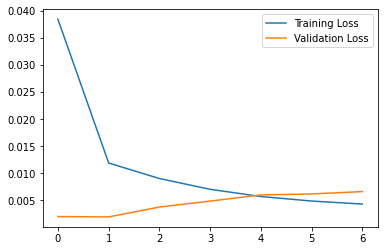

In [150]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [186]:
### Test the results
## use combine_labels as ground truth

# Get test MAE loss.
x_test_pred = model.predict(x_combine)
test_mae_loss = np.mean(np.abs(x_test_pred - x_combine), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

threshold = 0.05
# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))


Number of anomaly samples:  75559
Indices of anomaly samples:  (array([    0,     1,     2, ..., 78374, 78375, 78376]),)


In [187]:
print("number of attacks", np.sum(combine_labels), 'number of normal ', 
      len(combine_labels) - np.sum(combine_labels))

number of attacks 55663 number of normal  22714


In [188]:
def accuracy_labels(a,b):
    i=0
    n = 0
    p = 0
    fp = 0
    fn = 0
    ac = 0
    for i in range (0,len(a)):
        if (a[i] == False) and(b[i] == 0): # False and 0 is normal traffic right
            n = n + 1
            ac = ac + 1
        elif (a[i] == True) and (b[i]==1): # True (attack) and 1 attack is attack right
            p = p + 1
            ac = ac + 1
        elif (a[i] == False) and (b[i] == 1): # False (normal) and 1 is false negative
            fn = fn + 1
        elif (a[i] == True) and (b[i] == 0): # True (attack) and 0 is false positive
            fp = fp + 1
        else:
            print (a[i], b[i])
    print (i, '-> elements')
    return n, p, fp, fn, ac
            

In [189]:
neg, pos, false_pos, false_neg, accuracy = accuracy_labels(anomalies, combine_labels)

78376 -> elements


In [190]:
print ('accuracy :', accuracy/len(combine_labels))
print ('negatives :', neg)
print ('positives :', pos)
print ('false negatives :', false_neg)
print ('false positives :', false_pos)

accuracy : 0.6962118988989117
negatives : 861
positives : 53706
false negatives : 1957
false positives : 21853
